## Cost Models

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/cost_models.ipynb) (requires google account)


TOPFARM comes with two built-in cost models, a re-implementation of the **National Renewable Energy Laboratory (NREL) Cost and Scaling Model** provided by DTU and an original and more recent **DTU Cost Model**. Such models are currently being refined, so they are presented in this notebook in the form of toy-problems. Moreover, additional user-defined cost models can easily be integrated in the TOPFARM optimization problems as well. 

**Install TOPFARM if needed**

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

### Cost Model 1: DTU implementation of the NREL Cost and Scaling Model

First we are going to see the National Renewable Energy Laboratory (NREL) Cost and Scaling Model in its Python implementation provided by DTU. Such model is based on the 2006 _Wind Turbine Design Cost and Scaling Model_ technical report, which can be found [here](https://www.nrel.gov/docs/fy07osti/40566.pdf).

The model was developed from the early to mid-2000s as part of the Wind Partnership for Advanced Component Technology (WindPACT), which was at that time exploring innovative turbine design as well as innovations on the balance of plant and operations. Several detailed design studies on the turbine and plant design and cost were made; for publications associated with the WindPACT program, see: [WindPACT publication list](https://nrel.primo.exlibrisgroup.com/discovery/search?query=any,contains,windpact&tab=NREL_Publications&search_scope=NREL_Publications&vid=01NREL_INST:Pubs&offset=0).

The NREL cost and scaling model was developed starting from the WindPACT studies through a set of curve-fits, in order to underly detailed design data including:

- Turbine component masses and costs
- Balance of system costs
- Operational expenditures
- Financing and other costs

Over time, changes in turbine and plant technology have rendered the NREL cost and scaling model less used, but it is still useful as a publicly available, full Levelized Cost of Energy (LCoE) model for wind energy.

**Import Topfarm models to set up an LCOE workflow including the cost model**

In [1]:
# Import numerical python
import numpy as np

# Import pywake models including the IEA Wind Task 37 case study site, the Gaussian wake model and the AEP calculator
from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian

# Import Topfarm implementation of NREL Cost and Scaling model
from topfarm.cost_models.economic_models.turbine_cost import economic_evaluation as ee_1

# Import Topfarm constraints for site boundary and spacing
from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.constraint_components.boundary import CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint

# Import Topfarm support classes for setting up problem and workflow
from topfarm.cost_models.cost_model_wrappers import CostModelComponent, AEPCostModelComponent
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm import TopFarmGroup, TopFarmProblem
from topfarm.plotting import XYPlotComp, NoPlot

# Import Topfarm implementation of Random Search or Scipy drivers 
from topfarm.easy_drivers import EasyRandomSearchDriver
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.easy_drivers import EasySimpleGADriver

**Set up plotting capability**

In [2]:
try:
    import matplotlib.pyplot as plt
    plt.gcf()
    plot_comp = XYPlotComp()
    plot = True
except RuntimeError:
    plot_comp = NoPlot()
    plot = False

<Figure size 640x480 with 0 Axes>

**Set up IEA Wind Task 37 case study site with 16 turbines.**

In [3]:
# site set up
n_wt = 16 # number of wind turbines
site = IEA37Site(n_wt) # site is the IEA Wind Task 37 site with a circle boundary
windTurbines = IEA37_WindTurbines() # wind turbines are the IEA Wind Task 37 3.4 MW reference turbine
wake_model = IEA37SimpleBastankhahGaussian(site, windTurbines) # select the Gaussian wake model

# vectors for turbine properties: diameter, rated power and hub height. these are inputs to the cost model
Drotor_vector = [windTurbines.diameter()] * n_wt 
power_rated_vector = [float(windTurbines.power(20)/1000)] * n_wt 
hub_height_vector = [windTurbines.hub_height()] * n_wt 

**Set up functions for the AEP and cost calculations. Here we are using the internal rate of return (IRR) as our financial metric of interest.**

In [4]:
# function for calculating aep as a function of x,y positions of the wind turbiens
def aep_func(x, y, **kwargs):
    return wake_model(x, y).aep().sum(['wd','ws']).values*10**6

# function for calculating overall internal rate of return (IRR)
def irr_func(aep, **kwargs):
    my_irr = ee_1(Drotor_vector, power_rated_vector, hub_height_vector, aep).calculate_irr()
    #print(my_irr)
    return my_irr

**Now set up a problem to run an optimization using IRR as the objective function.**

Note that the turbines are fixed so the main driver changing the IRR will be the AEP as the turbine positions change. Here you can select different drivers to see how the optimization result changes.

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


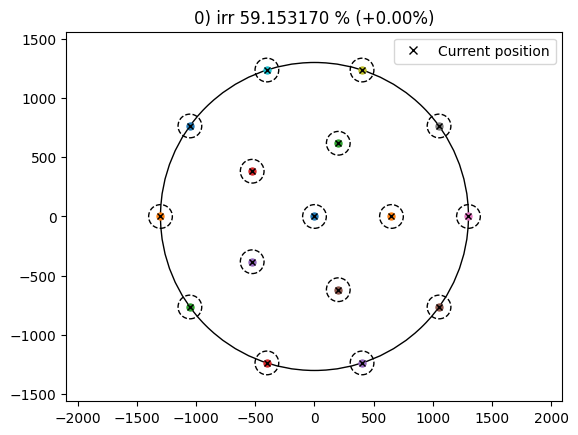

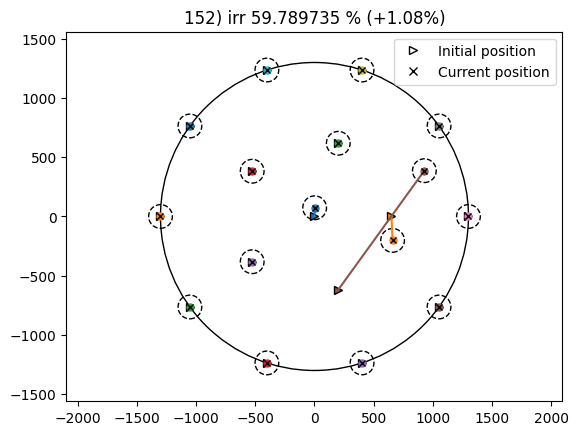

In [5]:
# create an openmdao component for aep and irr to add to the problem
aep_comp = CostModelComponent(input_keys=['x','y'],
                              n_wt=n_wt,
                              cost_function=aep_func,
                              output_keys="aep",
                              output_unit="GWh",
                              objective=False,
                              output_vals=np.zeros(n_wt))

irr_comp = CostModelComponent(input_keys=['aep'],
                              n_wt=n_wt,
                              cost_function=irr_func,
                              output_keys="irr",
                              output_unit="%",
                              objective=True,
                              maximize=True)

# create a group for the aep and irr components that links their common input/output (aep) 
irr_group = TopFarmGroup([aep_comp, irr_comp])

# add the group to an optimization problem and specify the design variables (turbine positions), 
# cost function (irr_group), and constraints (circular boundary and spacing)
problem = TopFarmProblem(
        design_vars=dict(zip('xy', site.initial_position.T)),
        n_wt = n_wt,
        cost_comp=irr_group,
    
        #specify driver to use: random search (gradient-free), COBYLA (gradient-free), genetic algorithm, GA (gradient-free)
        driver = EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition_Circle(), max_iter=50),
        #driver=EasyScipyOptimizeDriver(optimizer='COBYLA', maxiter=200, tol=1e-6, disp=False),
        #driver=EasySimpleGADriver(max_gen=100, pop_size=5, Pm=None, Pc=.5, elitism=True, bits={}),
        
        constraints=[SpacingConstraint(200),
                     CircleBoundaryConstraint([0, 0], 1300.1)],
        plot_comp=plot_comp)

# assign data from optimizationn to a set of accessible variables and run the optimization
cost, state, recorder = problem.optimize()

From the results it can be seen that the IRR has been increased by 1.76% from the baseline and it took 154 iterations while using the random search driver.

### Exercise

Play with the driver in the topfarm problem above to see if an improved objective function can be obtained.

### Cost Model 2: DTU Cost Model

The new DTU Cost Model is based on recent industrial data. Its structure is similar to the NREL cost and scaling model and it contains the major elements to calculate the LCoE, the IRR etcetera. As the DTU implementation of the NREL model, also the original DTU model is being refined; one innovative key element which will be introduced soon is the use of a detailed financial cash flow analysis.

More information about the background of the DTU Cost model can be found [here](https://topfarm.pages.windenergy.dtu.dk/TopFarm2/user_guide.html#dtu-cost-model), while the source code documentation can be found [here](https://topfarm.pages.windenergy.dtu.dk/TopFarm2/api_reference/dtucost.html).

**Import the new DTU Cost model**

In [6]:
#import the DTU cost model
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation as ee_2

**Set up the site and inputs as before but with additional cost variables.**

In [7]:
# site set up
n_wt = 16 # number of wind turbines
site = IEA37Site(n_wt) # site is the IEA Wind Task 37 site with a circle boundary
windTurbines = IEA37_WindTurbines() # wind turbines are the IEA Wind Task 37 3.4 MW reference turbine
wake_model = IEA37SimpleBastankhahGaussian(site, windTurbines) # select the Gaussian wake model
AEPComp = PyWakeAEPCostModelComponent(wake_model, n_wt) # set up AEP caculator to use Gaussiann model

# vectors for turbine properties: diameter, rated power and hub height. these are inputs to the cost model
Drotor_vector = [windTurbines.diameter()] * n_wt 
power_rated_vector = [float(windTurbines.power(20))*1e-6] * n_wt 
hub_height_vector = [windTurbines.hub_height()] * n_wt 

# add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 30         # [km]
energy_price = 0.1               # [Euro/kWh] What we get per kWh
project_duration = 20            # [years]    
rated_rpm_array = [12] * n_wt    # [rpm]
water_depth_array = [15] * n_wt  # [m]

**Set up the cost function to use the new DTU cost model.**

In [8]:
# set up function for new cost model with initial inputs as set above
eco_eval = ee_2(distance_from_shore, energy_price, project_duration)

# function for calculating aep as a function of x,y positions of the wind turbiens
def aep_func(x, y, **kwargs):
    return wake_model(x, y).aep().sum(['wd','ws']).values*10**6

# function for calculating overall internal rate of return (IRR)
def irr_func(aep, **kwargs):
    eco_eval.calculate_irr(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth_array, aep)
    #print(eco_eval.IRR)
    return eco_eval.IRR

**Set up rest of problem just as in prior example and run optimization with new model.**

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


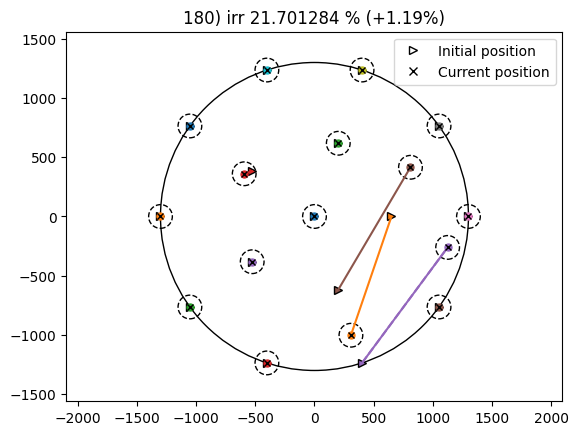

In [9]:
# create an openmdao component for aep and irr to add to the problem
aep_comp = CostModelComponent(input_keys=['x','y'],
                              n_wt=n_wt,
                              cost_function=aep_func,
                              output_keys="aep",
                              output_unit="kWh",
                              objective=False,
                              output_vals=np.zeros(n_wt))

irr_comp = CostModelComponent(input_keys=['aep'],
                              n_wt=n_wt,
                              cost_function=irr_func,
                              output_keys="irr",
                              output_unit="%",
                              objective=True,
                              maximize=True)

# create a group for the aep and irr components that links their common input/output (aep) 
irr_group = TopFarmGroup([aep_comp, irr_comp])

# add the group to an optimization problem and specify the design variables (turbine positions), 
# cost function (irr_group), driver (random search), and constraints (circular boundary and spacing)
problem = TopFarmProblem(
    design_vars=dict(zip('xy', site.initial_position.T)),
    n_wt = n_wt,
    cost_comp=irr_group,
    driver=EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition_Circle(), max_iter=50),
    constraints=[SpacingConstraint(200),
                 CircleBoundaryConstraint([0, 0], 1300.1)],
    plot_comp=plot_comp)
 
# assign data from optimizationn to a set of accessible variables and run the optimization
cost, state, recorder = problem.optimize()

In this example, the IRR percentage increase is similar to what observed in the NREL case. However, the final value is quite different (lower) and more iterations are necessary for the optimization to converge.

### Exercise

Manipulate the additional DTU cost model inputs to see how this influences the optimal IRR found.